# Cross validation splits for pHLA binding prediction

Similar to what is done in NetMHCpan paper, we will split the training-validation data using the Hobohom algorithm.

As described in the [NetMHCpan reference paper]( https://doi.org/10.1111/imm.12763):

>To minimize over‐estimation of predictive performance, these subsets for cross‐validation were created using a Hobohm1‐like algorithm called ‘common‐motif’.22 Common‐motif first selects seed sequences sharing at most a continuous stretch of eight amino acids, and then splits these seed sequences randomly into five partitions. The redundant sequences, i.e. those peptides with a common subsequence of nine or more contiguous amino acids, are then added to the group containing the seed used to define their redundancy.

Since this was applied for MHC class II, we will reduce the seed kmer to 5 and the redundant kmer to 5 (So there are no unasigned sequences). We will also use 5 folds for cross-validation.

In [1]:
import os
import random
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = '../data'
PROCESSED_DATA = os.path.join(DATA_DIR, 'processed')
INTERIM_DATA = os.path.join(DATA_DIR, 'interim')
PROCESSED_NETMHCPAN_DATA = os.path.join(PROCESSED_DATA, 'pHLA_binding', 'NetMHCpan_dataset')
INTERIM_NETMHCPAN_DATA = os.path.join(INTERIM_DATA, 'pHLA_binding', 'NetMHCpan_dataset')
test_netmhcpan_data_file = os.path.join(PROCESSED_NETMHCPAN_DATA, 'test_set_peptides_data_MaxLenPep15_hla_ABC.csv.gz')
train_ba_netmhcpan_data_file = os.path.join(PROCESSED_NETMHCPAN_DATA, 'train_binding_affinity_peptides_data_MaxLenPep15_hla_ABC.csv')
train_el_netmhcpan_data_file = os.path.join(PROCESSED_NETMHCPAN_DATA, 'train_eluted_ligand_peptides_data_mono_MaxLenPep15_hla_ABC.csv.gz')

In [5]:
def find_kmers(seq: str, k: int) -> set[str]:
    """
    Returns a set of all k-mers (contiguous substrings of length k) in a given sequence.
    """
    kmers = set()
    for i in range(len(seq) - k + 1):
        kmers.add(seq[i:i+k])
    return kmers


def has_common_kmer(seq1, seq2, k):
    """
    Checks if two sequences share a common k-mer.
    """
    kmers1 = find_kmers(seq1, k)
    kmers2 = find_kmers(seq2, k)
    return bool(kmers1.intersection(kmers2))


def split_common_motif(uniq_sequences, num_folds=5, seed_kmer=5, redundant_kmer=5, balance_splits=False, all_peptides_df=None, rand_seed=42):
    """
    Splits a list of sequences into non-redundant cross-validation folds using
    the "common-motif" procedure.
    """
    # Find seed sequences with no common seed_kmer
    # The bigger the seed_kmer, the more seeds you'll obtain and, 
    #  probably the more similar the seed sequences will be between them
    seed_sequences = []
    print(f'Finding seed sequences of len {seed_kmer}...')
    for seq in tqdm(uniq_sequences):
        is_seed = True
        for seed in seed_sequences:
            if has_common_kmer(seq, seed, seed_kmer):
                is_seed = False
                break
        if is_seed:
            seed_sequences.append(seq)
    print(f'Found {len(seed_sequences)} seed sequences.')
    
    # Assign remaining sequences to each seed. Make a dictionary of seed with all the sequences that includes it
    seed_to_sequences = defaultdict(list)
    assigned_sequences = set()  # To track assigned sequences
    print(f'Assigning sequences to seeds with redundant kmer {redundant_kmer}...')
    for seq in tqdm(uniq_sequences):
        for seed in seed_sequences:
            if has_common_kmer(seq, seed, redundant_kmer):
                if seq not in assigned_sequences:  # Ensure each sequence is only assigned once
                    seed_to_sequences[seed].append(seq)
                    assigned_sequences.add(seq)
                break # assign to the first seed that matches
                
    # Assert that all peptides in seed_to_sequences are only assigned once
    all_assigned_sequences = [seq for seq_list in seed_to_sequences.values() for seq in seq_list]
    assert len(all_assigned_sequences) == len(set(all_assigned_sequences)), 'All peptides should only appear once in seed_to_sequences'
    
    if balance_splits:
        assert all_peptides_df is not None, 'all_peptides_df should be a df with a column called peptide instead of None'
        assert len(all_peptides_df['peptide'].unique()) == len(uniq_sequences), 'all_peptides_df should have the same number of rows as sequences'
        print('Balancing splits')
        # Create a dictionary for peptide counts
        peptide_counts = all_peptides_df['peptide'].value_counts().to_dict()
        # Assign weight to each seed according to the number of sequences assigned to it and its frequency in the dataset
        #seed_weights = {seed: len(seq_list) * peptide_counts.get(seed, 0) for seed, seq_list in seed_to_sequences.items()}
        # Assign weight to each seed according to the sum of the counts of all peptides in seq_list
        seed_weights = {}
        for seed, seq_list in seed_to_sequences.items():
            weight = sum(peptide_counts.get(peptide, 0) for peptide in seq_list)
            # print(f'Seed {seed} has weight {weight} with sequences {seq_list}')
            seed_weights[seed] = weight
        
        # assert that all peptides only appear once in seed_to_sequences
        
        # Sort seeds by their weight in descending order
        sorted_seeds = sorted(seed_weights.items(), key=lambda item: item[1], reverse=True)
        
        # Initialize folds
        folds = [[] for _ in range(num_folds)]
        fold_weights = [0] * num_folds
        
        # Distribute seeds to folds
        for seed, weight in sorted_seeds:
            # Find the fold with the minimum total weight
            min_fold_index = fold_weights.index(min(fold_weights))
            # Assign the seed to this fold
            folds[min_fold_index].append(seed)
            # Update the weight of this fold
            fold_weights[min_fold_index] += weight
            
        # Collect sequences for each fold
        final_folds = [[] for _ in range(num_folds)]
        for fold_idx, seeds in enumerate(folds):
            for seed in seeds:
                final_folds[fold_idx].extend(seed_to_sequences[seed])
        
    else:
        # Randomly assign seeds to folds
        print('Randomly assign ')
        random.seed(rand_seed)
        random.shuffle(seed_sequences)
        final_folds = [[] for _ in range(num_folds)]
        for i, seed in enumerate(seed_sequences):
            fold_idx = i % num_folds
            final_folds[fold_idx].extend(seed_to_sequences[seed])
            
    # Assert that all peptides appear only once across all folds
    all_assigned_sequences = [seq for fold in final_folds for seq in fold]
    assert len(all_assigned_sequences) == len(set(all_assigned_sequences)), 'All peptides should only appear once across all folds'
        
    return final_folds
    

## Binding Affinity data

In [4]:
train_ba_netmhcpan_data = pd.read_csv(train_ba_netmhcpan_data_file)
unique_peptides = train_ba_netmhcpan_data['peptide'].unique()
unique_peptides.shape

(39029,)

In [6]:
folds = split_common_motif(unique_peptides, balance_splits=True, all_peptides_df=train_ba_netmhcpan_data)

Finding seed sequences of len 5...


100%|██████████| 39029/39029 [08:06<00:00, 80.16it/s] 


Found 19474 seed sequences.
Assigning sequences to seeds with redundant kmer 5...


100%|██████████| 39029/39029 [07:43<00:00, 84.16it/s] 


Balancing splits


In [7]:
print(f'Fold 0: {len(folds[0])}')
print(f'Fold 1: {len(folds[1])}')
print(f'Fold 2: {len(folds[2])}')
print(f'Fold 3: {len(folds[3])}')
print(f'Fold 4: {len(folds[4])}')

Fold 0: 7792
Fold 1: 7744
Fold 2: 7762
Fold 3: 7965
Fold 4: 7766


In [10]:
# Save folds
# for i, fold in enumerate(folds):
#     with open(os.path.join(INTERIM_NETMHCPAN_DATA, f'train_ba_peptides_balanced_split_{i}.txt'), 'w') as f:
#         for peptide in fold:
#             f.write(f'{peptide}\n')

# load folds
folds = []
for i in range(5):
    with open(os.path.join(INTERIM_NETMHCPAN_DATA, f'train_ba_peptides_balanced_split_{i}.txt'), 'r') as f:
        fold = [line.strip() for line in f]
        folds.append(fold)

print(f'Fold 0: {len(folds[0])}')
print(f'Fold 1: {len(folds[1])}')
print(f'Fold 2: {len(folds[2])}')
print(f'Fold 3: {len(folds[3])}')
print(f'Fold 4: {len(folds[4])}')

In [130]:
# Recover folds in the original dataframe
# peptide_fold_df = train_ba_netmhcpan_data.copy()
# peptide_fold_df['fold'] = '-'
# for i, fold in enumerate(folds): # skip fold 0 since it is already assigned
#     for peptide in tqdm(fold):
#         peptide_fold_df.loc[peptide_fold_df['peptide'] == peptide, 'fold'] = i
        
# peptide_fold_df.to_csv(os.path.join(PROCESSED_NETMHCPAN_DATA, 'train_ba_peptides_data_MaxLenPep15_hla_ABC_with_BalancedSplits.csv'), index=False)

# Load the dataframe with the folds
peptide_fold_df = pd.read_csv(os.path.join(PROCESSED_NETMHCPAN_DATA, 'train_ba_peptides_data_MaxLenPep15_hla_ABC_with_BalancedSplits.csv'))

In [9]:
peptide_fold_df.groupby('fold').size()

fold
0    34022
1    34022
2    34021
3    34021
4    34021
dtype: int64

In [12]:
# Num of labels 1 per fold
peptide_fold_df.groupby('fold')['label'].sum()

fold
0    8322
1    8395
2    8411
3    8650
4    8223
Name: label, dtype: int64

In [14]:
# Num of unique hla per fold
peptide_fold_df.groupby('fold')['hla_allele'].nunique()

fold
0    109
1    109
2    109
3    109
4    109
Name: hla_allele, dtype: int64

In [ ]:
# make bar plot of the number of pHLA per length per fold
peptide_lengths_df = peptide_fold_df.copy()
peptide_lengths_df['peptide_length'] = peptide_lengths_df['peptide'].apply(len)
plt.figure(figsize=(12, 6))
sns.countplot(data=peptide_lengths_df, x='peptide_length', hue='fold', palette='viridis')
plt.title('Number of peptides per length per fold')


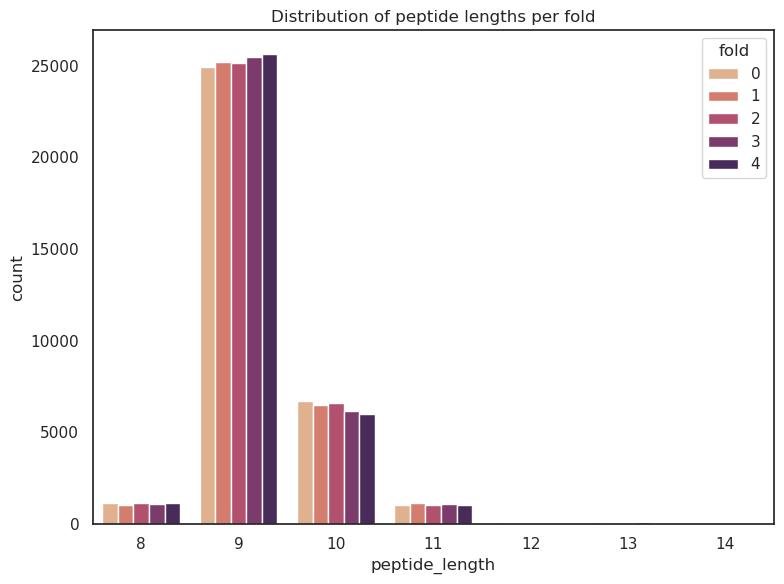

In [49]:
# Plot the distribution of peptide lengths per fold
peptide_lengths_df = peptide_fold_df.copy()
peptide_lengths_df['peptide_length'] = peptide_lengths_df['peptide'].apply(len)
plt.figure(figsize=(8, 6))
sns.countplot(peptide_lengths_df, x="peptide_length", hue="fold", palette='flare')
plt.title('Distribution of peptide lengths per fold')
plt.tight_layout()
plt.savefig(os.path.join('.', 'peptide_lengths_per_fold.png'))
#plt.ylim(0,500)
plt.show()

In [125]:
# Make a tsne plot of the unique peptides and color them by fold
import numpy as np
from nimbus.data_processing import SeqTokenizer

tokenizer = SeqTokenizer()
encoded_folds = []
fold_id = []
for i in range(5):
    
    encoded_fold = np.array([tokenizer.encode(seq + tokenizer.padding_token[0] * (15 - len(seq))) for seq in folds[i]])
    fold_id.extend([i] * len(encoded_fold))
    # one hot encode with numpy eye
    # encoded_fold = np.eye(len(tokenizer.tokens))[encoded_fold]
    encoded_folds.extend(encoded_fold)

encoded_folds = np.array(encoded_folds)
print(encoded_folds.shape)

(39029, 15)


In [159]:
import umap.umap_ as umap

umap = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
)

# Flatten if one hot encoded
# flattened_encoding = encoded_folds.reshape(encoded_folds.shape[0], -1)
# X_umap = umap.fit_transform(flattened_encoding)
X_umap = umap.fit_transform(encoded_folds)

In [160]:
import plotly.express as px

df = pd.DataFrame(X_umap, columns=['UMAP 1', 'UMAP 2'])
df['fold'] = fold_id
df['fold'] = df['fold'].astype(str)
df['peptide'] = folds[0] + folds[1] + folds[2] + folds[3] + folds[4]
fig = px.scatter(df, x='UMAP 1', y='UMAP 2', color='fold', hover_data=['peptide'],
                 opacity=0.5,
                 color_discrete_sequence=px.colors.qualitative.Plotly_r)
fig.update_layout(
    title='UMAP plot of unique peptides colored by fold',
    xaxis_title='UMAP 1',
    yaxis_title='UMAP 2',
    template='simple_white',
    showlegend=True,
    font={'family': "Arial"}, width=800, height=800,
)
fig.show()